Source: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 2. Dataset

## Use tweets of today to predict stonk prices tomorrow

## Lets process tweets first

In [2]:
tweets = pd.read_csv('tweetData/elonmusk_2021-01-01_2021-05-15.csv')
tweets = tweets[tweets["UserName"] == "@elonmusk"]

tweets["Timestamp"] = tweets["Timestamp"] = pd.to_datetime(tweets["Timestamp"])
tweets["TimestampDay"] = tweets["Timestamp"].dt.date.astype('datetime64')

tweets["Text"] = tweets["Text"].fillna('')

tweets

,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL,TimestampDay
1,Elon Musk,@elonmusk,2021-01-01 00:58:30+00:00,"Dojo isn’t needed, but will make self-driving ...",NaN,NaN,224,258,3.6K,[],https://twitter.com/elonmusk/status/1344810193...,2021-01-01
3,Elon Musk,@elonmusk,2021-01-02 12:23:28+00:00,"Um, we have giant fusion reactor in the sky th...",NaN,NaN,1.9K,2.7K,53.2K,[],https://twitter.com/elonmusk/status/1345344958...,2021-01-02
5,Elon Musk,@elonmusk,2021-01-02 03:20:48+00:00,Tesla Full Self-Driving will work at a safety ...,NaN,NaN,687,1.1K,20.7K,[],https://twitter.com/elonmusk/status/1345208391...,2021-01-02
7,Elon Musk,@elonmusk,2021-01-02 14:59:09+00:00,Tesla is responsible for 2/3 of all the person...,NaN,NaN,654,822,13.2K,[],https://twitter.com/elonmusk/status/1345384139...,2021-01-02
8,Elon Musk,@elonmusk,2021-01-02 14:51:49+00:00,So proud of the Tesla team for achieving this ...,"Tesla\n@Tesla\n · Jan 2\nIn 2020, we produced ...",NaN,4.1K,6.9K,110.7K,['https://pbs.twimg.com/profile_images/1337607...,https://twitter.com/elonmusk/status/1345382294...,2021-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...
1130,Elon Musk,@elonmusk,2021-05-13 22:45:16+00:00,Working with Doge devs to improve system trans...,NaN,NaN,59.6K,103.4K,504.2K,[],https://twitter.com/elonmusk/status/1392974251...,2021-05-13
1131,Elon Musk,@elonmusk,2021-05-13 20:21:45+00:00,Replying to \n@michael_saylor,https://arstechnica.com/tech-policy/2021/05/pr...,NaN,3.1K,1.7K,7.2K,['https://pbs.twimg.com/card_img/1390601602243...,https://twitter.com/elonmusk/status/1392938133...,2021-05-13
1133,Elon Musk,@elonmusk,2021-05-14 04:42:32+00:00,3/4 of the way around the Earth,NaN,NaN,1.2K,1.6K,23.4K,[],https://twitter.com/elonmusk/status/1393064162...,2021-05-14
1135,Elon Musk,@elonmusk,2021-05-14 05:58:35+00:00,We need to make sure ship won’t break up on re...,NaN,NaN,552,725,10.3K,[],https://twitter.com/elonmusk/status/1393083299...,2021-05-14


In [3]:
unique_days = tweets["TimestampDay"].unique()

In [4]:
def allTweets(day):
    """
    Returns all tweet text combined tweeted on given day
    """
    return ' | '.join(tweets[tweets["TimestampDay"] == day]["Text"])

allTweets(unique_days[1])

'Um, we have giant fusion reactor in the sky that works with no maintenance | Tesla Full Self-Driving will work at a safety level well above that of the average driver this year, of that I am confident. Can’t speak for regulators though. | Tesla is responsible for 2/3 of all the personal & professional pain in my life combined. But it was worth it. | So proud of the Tesla team for achieving this major milestone! At the start of Tesla, I thought we had (optimistically) a 10% chance of surviving at all. | Replying to \n@Gfilche'

## Let's process stonks now

In [5]:
prices = pd.read_csv('stonkData/DOGE-USD.csv')
prices["Date"] = pd.to_datetime(prices["Date"]).dt.date.astype('datetime64')
prices["Close Pct Change"] = prices["Close"].pct_change()
prices

,Date,Open,High,Low,Close,Adj Close,Volume,Close Pct Change
0,2021-01-01,0.004681,0.005685,0.004615,0.005685,0.005685,228961515,NaN
1,2021-01-02,0.005686,0.013698,0.005584,0.010615,0.010615,3421562680,0.867194
2,2021-01-03,0.010602,0.013867,0.009409,0.009771,0.009771,2707003608,-0.079510
3,2021-01-04,0.009785,0.011421,0.007878,0.009767,0.009767,1372398979,-0.000409
4,2021-01-05,0.009767,0.010219,0.008972,0.009920,0.009920,687256067,0.015665
...,...,...,...,...,...,...,...,...
136,2021-05-17,0.513413,0.515221,0.458551,0.487892,0.487892,7330830504,-0.052444
137,2021-05-18,0.486954,0.515599,0.470384,0.476115,0.476115,4802902841,-0.024139
138,2021-05-19,0.476435,0.684735,0.218267,0.333123,0.333123,15072620946,-0.300331
139,2021-05-20,0.330252,0.433192,0.296253,0.400194,0.400194,12415484460,0.201340


In [6]:
# Test it

prices["Close"][0] + prices["Close"][0] * .8672

0.010615032

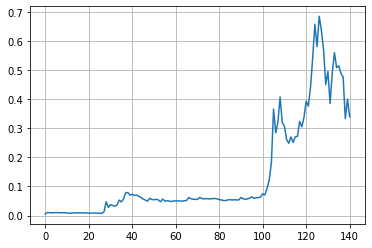

In [7]:
fig = plt.plot(prices["Close"])
plt.grid()

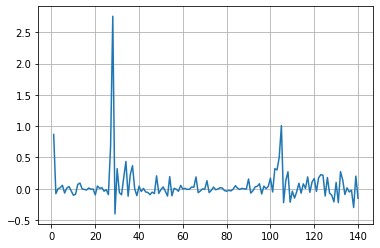

In [8]:
fig = plt.plot(prices["Close Pct Change"])
plt.grid()

In [9]:
def getPair(day, verbose=False):
    tweetsThatDay = allTweets(day)
    nextDay = day + np.timedelta64(1,'D')
    closePctChange = prices[prices["Date"] == nextDay]["Close Pct Change"].iloc[0]
    
    if verbose:
        print("On " + str(day))
        print("Tweets were")
        print(tweetsThatDay)
        print("Percent change on " + str(nextDay))
        print("Was")
        print(closePctChange)
    
    return (tweetsThatDay, closePctChange)

In [10]:
tweetsThatDay, closing = getPair(unique_days[0], verbose=True)

On 2021-01-01T00:00:00.000000000
Tweets were
Dojo isn’t needed, but will make self-driving better. It isn’t enough to be safer than human drivers, Autopilot ultimately needs to be more than 10 times safer than human drivers.
Percent change on 2021-01-02T00:00:00.000000000
Was
0.8671943711521548


## Build the dataset by getting pairs for each unique day

In [11]:
dataset = []

for day in unique_days[:-1]:
    tweetsThatDay, closePctChange = getPair(day)
    dataset += [(tweetsThatDay, closePctChange)]

In [12]:
data = pd.DataFrame(dataset)
data = data.rename(columns={0: "tweet", 1: "label"})
data["id"] = data.index
data

,tweet,label,id
0,"Dojo isn’t needed, but will make self-driving ...",0.867194,0
1,"Um, we have giant fusion reactor in the sky th...",-0.079510,1
2,Replying to \n@RGVaerialphotos\n and \n@SpaceX,-0.000409,2
3,Snow falling on Giga Berlin | Because of the l...,0.015665,3
4,Replying to \n@Dtrford\n @austinbarnard45\n an...,0.054940,4
...,...,...,...
85,Wario was my fav haha | SpaceX launching sate...,-0.210686,85
86,"Thanks again to \n@nbcsnl\n cast, writers & cr...",0.100601,86
87,Do you want Tesla to accept Doge? | Exactly | ...,-0.221826,87
88,Tesla & Bitcoin | Subscription rolls out in ab...,0.272456,88


We will randomly split the entire training data into two sets: a train set with 90% of the data and a validation set with 10% of the data. We will perform hyperparameter tuning using cross-validation on the train set and use the validation set to compare models.

In [13]:
from sklearn.model_selection import train_test_split

X = data.tweet.values
y = data.label.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=37)

print("X_train shape", X_train.shape)
print("X_val shape", X_val.shape)

X_train shape (81,)
X_val shape (9,)


## 3. Set up GPU for training

In [14]:
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: GeForce GTX TITAN X


# D - Fine-tuning BERT

## 1. Install the Hugging Face Library

The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [15]:
!pip install transformers==2.8.0

## 2. Tokenization and Input Formatting

Before tokenizing our text, we will perform some slight processing on our text including removing entity mentions (eg. @united) and some special character. The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences.

In [16]:
def text_preprocessing(text):
    """
    - Correct errors (eg. '&amp;' to '&')
    - Make all lowercase
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    text = text.lower()

    return text

In [17]:
# Print sentence 0
print('Original: \n', X[0])
print()
print('Processed: \n', text_preprocessing(X[0]))

Original: 
 Dojo isn’t needed, but will make self-driving better. It isn’t enough to be safer than human drivers, Autopilot ultimately needs to be more than 10 times safer than human drivers.

Processed: 
 dojo isn’t needed, but will make self-driving better. it isn’t enough to be safer than human drivers, autopilot ultimately needs to be more than 10 times safer than human drivers.


### 2.1. BERT Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The `encode_plus` method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special `[CLS]` and `[SEP]` tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.






In [18]:
from transformers import BertTokenizer
from IPython.display import clear_output

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    
    i = 0
    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        i = i + 1
        if i % 1000 == 0:
            clear_output(wait=True)
            print("Tokenized:", i)
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.

In [19]:
# Specify `MAX_LEN`
MAX_LEN = 512

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: \n', X[0])
print()
print('Token IDs: \n', token_ids)

Original: 
 Dojo isn’t needed, but will make self-driving better. It isn’t enough to be safer than human drivers, Autopilot ultimately needs to be more than 10 times safer than human drivers.

Token IDs: 
 [101, 2079, 5558, 3475, 1521, 1056, 2734, 1010, 2021, 2097, 2191, 2969, 1011, 4439, 2488, 1012, 2009, 3475, 1521, 1056, 2438, 2000, 2022, 13726, 2084, 2529, 6853, 1010, 8285, 8197, 10994, 4821, 3791, 2000, 2022, 2062, 2084, 2184, 2335, 13726, 2084, 2529, 6853, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
print('Done!')

Tokenizing data...
Done!


### 2.2. Create PyTorch DataLoader

We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [38]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train, dtype=torch.float64)
val_labels = torch.tensor(y_val, dtype=torch.float64)

train_labels = torch.unsqueeze(train_labels, 1)
val_labels = torch.unsqueeze(val_labels, 1)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 8

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## 3. Train Our Model

### 3.1. Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The `transformers` library has the [`BertForSequenceClassification`](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the `[CLS]` token and a single-hidden-layer feed-forward neural network as our classifier.

In [41]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 1

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 64 µs, sys: 4 µs, total: 68 µs
Wall time: 74.9 µs


### 3.2. Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) script, an examples of implementing the `transformers` library. In the script, the AdamW optimizer is used.

In [42]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    
    return bert_classifier, optimizer, scheduler

### 3.3. Training Loop

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (`loss.backward()`)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (`optimizer.step()`)
- Update the learning rate (`scheduler.step()`)

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop. 

In [43]:
import random
import time

# Specify loss function
loss_fn = nn.MSELoss()

def set_seed(seed_value=37):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()
            
            # Perform a forward pass.

            logits = model(b_input_ids, b_attn_mask)
            
            # Compute loss and accumulate the loss values
            
            loss = loss_fn(logits.float(), b_labels.float())
                        
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
            
            # Free up GPU memory?
            del b_input_ids
            del b_attn_mask
            del b_labels

            # Print the loss values and time elapsed
            if (step % 4096 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results                
                val_loss, val_accuracy = evaluate(model, val_dataloader)
                
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
                #print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        # preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        # accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(0) # (accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Now, let's start training our BertClassifier!

In [44]:
set_seed(37)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=1)

In [45]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [47]:
train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([8, 1])
torch.Size([1, 1])
torch.Size([1, 1])
   1    |   10    |   0.120363   |  0.012930  |   0.00    |   7.03   
----------------------------------------------------------------------
   1    |    -    |   0.120363   |  0.012930  |   0.00    |   7.54   
----------------------------------------------------------------------


Training complete!


In [28]:
# save
torch.save({
    'model_state_dict': bert_classifier.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "full_dataset_train_2")

In [29]:
torch.cuda.empty_cache()

### 3.4. Evaluation on Validation Set

The prediction step is similar to the evaluation step that we did in the training loop.

In [48]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    return all_logits

In [49]:
# Compute predicted probabilities on the test set
all_logits = bert_predict(bert_classifier, val_dataloader)
all_logits

tensor([[ 0.0302],
        [ 0.0288],
        [ 0.0379],
        [ 0.0534],
        [ 0.0376],
        [ 0.0325],
        [ 0.0353],
        [ 0.0352],
        [-0.0011]], device='cuda:0')

## 4. Predictions on Test Set

### 4.1. Data Preparation

In [50]:
def predict(texts):
    inputs, masks = preprocessing_for_bert(texts)
    dataset = TensorDataset(inputs, masks)
    sampler = SequentialSampler(dataset)
    loader = DataLoader(dataset, sampler=sampler, batch_size=len(texts))
    logits = bert_predict(bert_classifier, loader)
    
    for i, pc in enumerate(logits):
        print("tweets:", texts[i])
        print("perc change:", pc[0])
        print()

predict(["Doge",
        "Bitcoin",
        "Terrible",
        "Amazing",
        "To the moon!",
        "I'm selling all my doge, sell bitcoin, crash, done, over"])

tweets: Doge
perc change: tensor(0.0163, device='cuda:0')

tweets: Bitcoin
perc change: tensor(0.0542, device='cuda:0')

tweets: Terrible
perc change: tensor(0.0199, device='cuda:0')

tweets: Amazing
perc change: tensor(0.0169, device='cuda:0')

tweets: To the moon!
perc change: tensor(0.0139, device='cuda:0')

tweets: I'm selling all my doge, sell bitcoin, crash, done, over
perc change: tensor(0.0080, device='cuda:0')



In [33]:
def predictOne(text):
    inputs, masks = preprocessing_for_bert([text])
    dataset = TensorDataset(inputs, masks)
    sampler = SequentialSampler(dataset)
    loader = DataLoader(dataset, sampler=sampler, batch_size=1)
    logits = bert_predict(bert_classifier, loader)
    return logits[0].cpu()[0].item()

predictOne("Buy")

0.05244927108287811

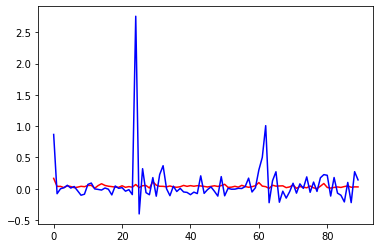

In [34]:
preds = []
actual = []
for twts, pc in dataset:
    preds += [predictOne(twts)]
    actual += [pc]
    
fig = plt.plot(preds, c='red')
fig = plt.plot(actual, c='blue')

### Save the model

In [35]:
# save
torch.save({
    'model_state_dict': bert_classifier.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "test")

In [36]:
# load
checkpoint = torch.load('test', map_location='cpu')
bert_classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# E - Conclusion

By adding a simple one-hidden-layer neural network classifier on top of BERT and fine-tuning BERT, we can achieve near state-of-the-art performance, which is 10 points better than the baseline method although we only have 3,400 data points.

In addition, although BERT is very large, complicated, and have millions of parameters, we only need to fine-tune it in only 2-4 epochs. That result can be achieved because BERT was trained on the huge amount and already encode a lot of information about our language. An impresive performance achieved in a short amount of time, with a small amount of data has shown why BERT is one of the most powerful NLP models available at the moment. 